## GNN

### Подготовка к работе

In [20]:
! pip install biopandas

In [21]:
import numpy as np
import torch
from biopandas.pdb import PandasPdb
from itertools import combinations
from torch_geometric.data import Data

### Подготовка данных

In [22]:
def pdb_to_pyg_graph(pdb_file: str, target: float, distance_threshold: float = 5.0) -> Data:
    ppdb = PandasPdb().read_pdb(pdb_file)
    atoms = ppdb.df['ATOM']

    # Группировка атомов по остатку (chain_id, residue_number)
    atoms['res_id'] = atoms['chain_id'].astype(str) + "_" + atoms['residue_number'].astype(str)
    residue_groups = atoms.groupby('res_id')

    residues = list(residue_groups.groups.keys())
    num_nodes = len(residues)

    # Собираем координаты и имена остатков
    residue_coords = []
    residue_names = []

    for res_id in residues:
        group = residue_groups.get_group(res_id)
        coords = group[['x_coord', 'y_coord', 'z_coord']].values
        residue_coords.append(coords)
        residue_names.append(group['residue_name'].values[0])  # Одно имя на остаток

    # One-hot кодировка аминокислот
    aa_list = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
               'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
               'TYR', 'VAL']
    aa_to_idx = {aa: i for i, aa in enumerate(aa_list)}
    aa_indices = [aa_to_idx.get(res, len(aa_list)) for res in residue_names]
    one_hot = np.zeros((num_nodes, len(aa_list)+1))  # +1 для unknown
    one_hot[np.arange(num_nodes), aa_indices] = 1

    # В качестве координат узла можно взять центр масс или просто среднее
    centers = np.array([coords.mean(axis=0) for coords in residue_coords])

    # Узловые признаки: средние координаты + one-hot кодировка
    x = torch.tensor(np.concatenate([centers, one_hot], axis=1), dtype=torch.float)

    # Построение рёбер: расстояние между всеми парами остатков по минимальному расстоянию между атомами
    edge_index = []
    edge_attr = []

    for i, j in combinations(range(num_nodes), 2):
        coords_i = residue_coords[i]
        coords_j = residue_coords[j]

        dists = np.linalg.norm(coords_i[:, None, :] - coords_j[None, :, :], axis=2)
        min_dist = np.min(dists)

        if min_dist <= distance_threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])
            edge_attr.append([min_dist])
            edge_attr.append([min_dist])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    y = torch.tensor([target], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [23]:
graph = pdb_to_pyg_graph("/home/paa/Develop/biocadprotein/data/archive/pdb_active_sites/radius_8/1AFJZ.pdb", 1.843934)
graph.get_edge_index

<bound method GraphStore.get_edge_index of Data(x=[127, 24], edge_index=[2, 994], edge_attr=[994, 1], y=[1])>

In [24]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

def visualize_pyg_graph(data, dim=2, node_label_attr='residue_name'):
    # Преобразуем PyG Data в NetworkX граф
    G = to_networkx(data, to_undirected=True)

    # Координаты узлов для отрисовки
    if dim == 2:
        pos = {i: (data.x[i][0].item(), data.x[i][1].item()) for i in range(data.num_nodes)}
    elif dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for i, (xi, yi, zi) in enumerate(data.x[:, :3]):
            ax.scatter(xi, yi, zi, color='skyblue')
            ax.text(xi, yi, zi, str(i), size=6)
        for i, j in data.edge_index.T:
            xi, yi, zi = data.x[i][:3]
            xj, yj, zj = data.x[j][:3]
            ax.plot([xi, xj], [yi, yj], [zi, zj], color='gray', alpha=0.5)
        ax.set_title(f"3D Graph: {getattr(data, 'protein_name', '')}")
        plt.show()
        return

    # 2D-граф через networkx
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color='lightblue', edge_color='gray', with_labels=False, node_size=300)
    plt.title(f"2D Projection of Graph: {getattr(data, 'protein_name', '')}")
    plt.show()

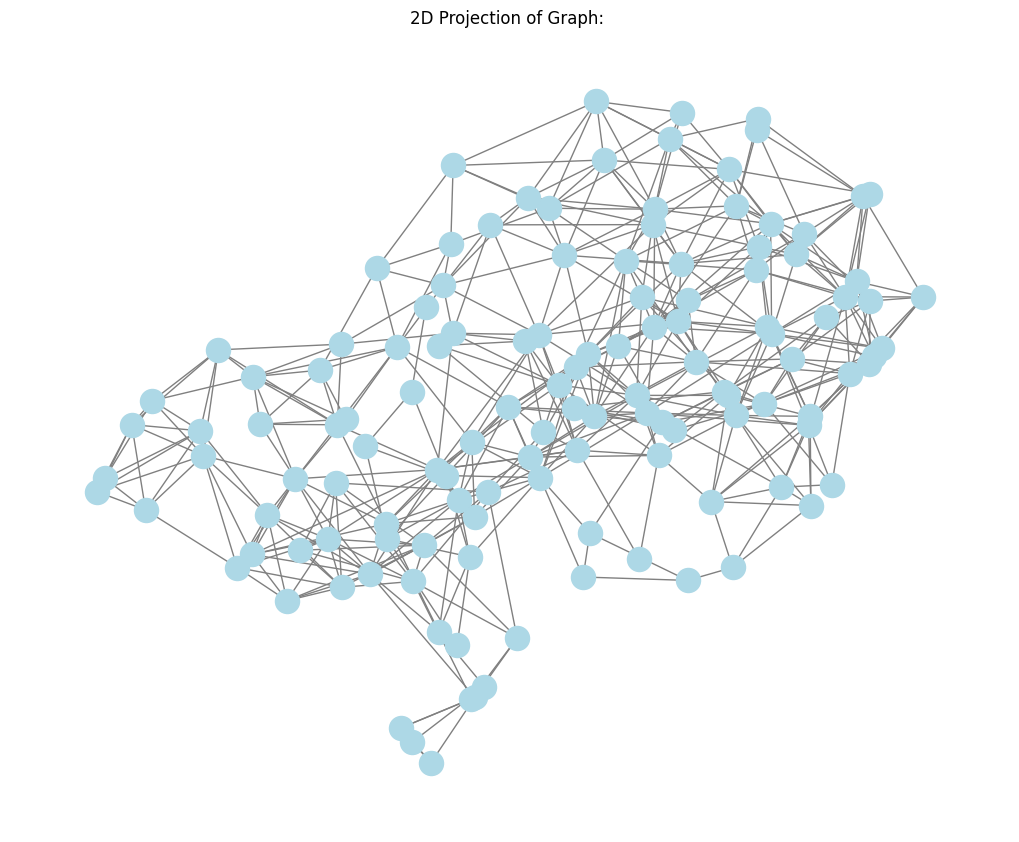

In [25]:
visualize_pyg_graph(graph)

In [26]:
from fpgen.prop_prediction.dataset import FPbase

In [27]:
dataset = FPbase('../data/dataset.csv')

In [31]:
x_train, y_train = dataset.get_train('em_max', additional_feature_columns=['id'])
x_test, y_test = dataset.get_test('em_max', additional_feature_columns=['id'])

In [32]:
path = '/home/paa/Develop/biocadprotein/data/archive/pdb_active_sites/radius_4/'

def preprocessing_dataset(x, y):
    graph = []
    for i in range(len(x)):
        id = x.iloc[i]['id']
        if id != '7XHKJ':
            g = pdb_to_pyg_graph(f'{path}{id}.pdb', y[i])
            graph.append(g)
    return graph

In [33]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(preprocessing_dataset(x_train, y_train), test_size=0.2, random_state=52)
test = preprocessing_dataset(x_test, y_test)

In [34]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train, batch_size=16, shuffle=True)
test_loader = DataLoader(test, batch_size=16, shuffle=False)
val_loader = DataLoader(val, batch_size=16, shuffle=False)

/home/paa/Develop/biocadprotein/.venv/lib64/python3/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Архитектура модели

In [35]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, Sequential, ReLU
from torch_geometric.nn import GINEConv, global_add_pool
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.data import Data

class FluoroGNN(torch.nn.Module):
    """
    GNN для предсказания одного спектрального параметра
    (например, brightness) по структуре белка.
    """
    def __init__(self,
                 in_channels: int,
                 hidden_dim: int = 128,
                 num_layers: int = 4):
        super().__init__()

        self.num_gaussians = 32
        self.register_buffer('offsets', torch.linspace(0, 10, self.num_gaussians))
        self.register_buffer('widths', torch.full((self.num_gaussians,), 0.5))

        self.node_embed = Linear(in_channels, hidden_dim)

        self.convs = ModuleList()
        self.norms = ModuleList()
        for _ in range(num_layers):
            mlp = Sequential(
                Linear(hidden_dim, hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim)
            )
            conv = GINEConv(mlp, edge_dim=self.num_gaussians)
            self.convs.append(conv)
            self.norms.append(GraphNorm(hidden_dim))

        # Один выходной нейрон — регрессия
        self.head = Sequential(
            Linear(hidden_dim, hidden_dim), ReLU(),
            Linear(hidden_dim, hidden_dim // 2), ReLU(),
            Linear(hidden_dim // 2, 1)  # ⬅️ только один выход
        )

    def gaussian_smearing(self, distances: torch.Tensor) -> torch.Tensor:
        diff = distances.unsqueeze(1) - self.offsets.unsqueeze(0)
        return torch.exp(-0.5 * (diff / self.widths.unsqueeze(0)) ** 2)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr.squeeze()
        x = self.node_embed(x)
        edge_emb = self.gaussian_smearing(edge_attr)

        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_emb)
            x = norm(x)
            x = F.relu(x)

        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        h = global_add_pool(x, batch)
        out = self.head(h)  # [batch_size, 1]
        return out.squeeze(-1)  # ⬅️ делаем [batch_size] для удобства


### Обучение модели

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FluoroGNN(in_channels=24).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()  # так как регрессия

In [37]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        '''
        print("x:", data.x.shape)
        print("y:", data.y.shape)
        print("batch:", data.batch.shape)
        '''
        target = data.y.view(-1)

        optimizer.zero_grad()
        out = model(data)  # [batch_size, 6]
        #print(out.shape)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [38]:
def evaluate(model, loader, return_preds=False):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)  # [batch_size]
            target = data.y.squeeze()  # Убедись, что размерности совпадают
            loss = loss_fn(out, target)
            total_loss += loss.item()

            if return_preds:
                all_preds.append(out.cpu())
                all_targets.append(target.cpu())

    if return_preds:
        y_pred = torch.cat(all_preds).numpy()
        y_true = torch.cat(all_targets).numpy()
        return y_pred, y_true

    return total_loss / len(loader)


In [39]:
from tqdm import tqdm

best_val_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(100)):
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]/home/paa/Develop/biocadprotein/.venv/lib64/python3/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:02<04:52,  2.96s/it]

Epoch 0 | Train Loss: 1.6382 | Val Loss: 0.8859


  2%|▏         | 2/100 [00:06<05:03,  3.10s/it]

Epoch 1 | Train Loss: 1.1667 | Val Loss: 0.8659


  3%|▎         | 3/100 [00:09<05:05,  3.15s/it]

Epoch 2 | Train Loss: 1.0554 | Val Loss: 1.0617


  4%|▍         | 4/100 [00:12<04:56,  3.09s/it]

Epoch 3 | Train Loss: 1.3094 | Val Loss: 0.8835


  5%|▌         | 5/100 [00:15<04:51,  3.07s/it]

Epoch 4 | Train Loss: 0.8528 | Val Loss: 0.6852


  6%|▌         | 6/100 [00:18<04:57,  3.16s/it]

Epoch 5 | Train Loss: 0.6984 | Val Loss: 0.5973


  7%|▋         | 7/100 [00:22<04:58,  3.21s/it]

Epoch 6 | Train Loss: 0.6152 | Val Loss: 0.6876


  8%|▊         | 8/100 [00:25<04:53,  3.19s/it]

Epoch 7 | Train Loss: 0.6460 | Val Loss: 0.6940


  9%|▉         | 9/100 [00:28<04:45,  3.14s/it]

Epoch 8 | Train Loss: 0.7026 | Val Loss: 0.8918


 10%|█         | 10/100 [00:31<04:41,  3.13s/it]

Epoch 9 | Train Loss: 0.5962 | Val Loss: 0.6890


 11%|█         | 11/100 [00:34<04:43,  3.19s/it]

Epoch 10 | Train Loss: 0.6898 | Val Loss: 1.0943


 12%|█▏        | 12/100 [00:38<04:44,  3.24s/it]

Epoch 11 | Train Loss: 0.6309 | Val Loss: 0.8315


 13%|█▎        | 13/100 [00:41<04:44,  3.27s/it]

Epoch 12 | Train Loss: 0.6000 | Val Loss: 0.6311


 14%|█▍        | 14/100 [00:44<04:41,  3.28s/it]

Epoch 13 | Train Loss: 0.6563 | Val Loss: 0.8470


 15%|█▌        | 15/100 [00:47<04:38,  3.28s/it]

Epoch 14 | Train Loss: 0.6707 | Val Loss: 0.6166


 16%|█▌        | 16/100 [00:51<04:35,  3.28s/it]

Epoch 15 | Train Loss: 0.6105 | Val Loss: 0.6366


 17%|█▋        | 17/100 [00:54<04:33,  3.29s/it]

Epoch 16 | Train Loss: 0.5614 | Val Loss: 0.5686


 18%|█▊        | 18/100 [00:57<04:30,  3.30s/it]

Epoch 17 | Train Loss: 0.5252 | Val Loss: 0.5583


 19%|█▉        | 19/100 [01:01<04:26,  3.29s/it]

Epoch 18 | Train Loss: 0.4771 | Val Loss: 0.6312


 20%|██        | 20/100 [01:04<04:23,  3.30s/it]

Epoch 19 | Train Loss: 0.4580 | Val Loss: 0.5738


 21%|██        | 21/100 [01:07<04:20,  3.29s/it]

Epoch 20 | Train Loss: 0.4561 | Val Loss: 0.5698


 22%|██▏       | 22/100 [01:10<04:11,  3.22s/it]

Epoch 21 | Train Loss: 0.4082 | Val Loss: 0.6032


 23%|██▎       | 23/100 [01:14<04:10,  3.25s/it]

Epoch 22 | Train Loss: 0.4998 | Val Loss: 0.5215


 24%|██▍       | 24/100 [01:17<04:08,  3.27s/it]

Epoch 23 | Train Loss: 0.4110 | Val Loss: 0.5287


 25%|██▌       | 25/100 [01:20<04:06,  3.29s/it]

Epoch 24 | Train Loss: 0.4368 | Val Loss: 0.6343


 26%|██▌       | 26/100 [01:24<04:05,  3.31s/it]

Epoch 25 | Train Loss: 0.3872 | Val Loss: 0.5262


 27%|██▋       | 27/100 [01:27<04:02,  3.32s/it]

Epoch 26 | Train Loss: 0.3190 | Val Loss: 0.6253


 28%|██▊       | 28/100 [01:30<03:59,  3.32s/it]

Epoch 27 | Train Loss: 0.3883 | Val Loss: 0.6426


 29%|██▉       | 29/100 [01:34<03:56,  3.33s/it]

Epoch 28 | Train Loss: 0.3869 | Val Loss: 0.5966


 30%|███       | 30/100 [01:37<03:52,  3.32s/it]

Epoch 29 | Train Loss: 0.3378 | Val Loss: 0.4976


 31%|███       | 31/100 [01:40<03:46,  3.29s/it]

Epoch 30 | Train Loss: 0.3562 | Val Loss: 0.7092


 32%|███▏      | 32/100 [01:43<03:43,  3.29s/it]

Epoch 31 | Train Loss: 0.3253 | Val Loss: 0.5549


 33%|███▎      | 33/100 [01:47<03:41,  3.31s/it]

Epoch 32 | Train Loss: 0.5436 | Val Loss: 0.6382


 34%|███▍      | 34/100 [01:50<03:32,  3.22s/it]

Epoch 33 | Train Loss: 0.3921 | Val Loss: 0.5657


 35%|███▌      | 35/100 [01:53<03:31,  3.26s/it]

Epoch 34 | Train Loss: 0.5162 | Val Loss: 0.5834


 36%|███▌      | 36/100 [01:57<03:31,  3.30s/it]

Epoch 35 | Train Loss: 0.3872 | Val Loss: 0.5801


 37%|███▋      | 37/100 [02:00<03:28,  3.31s/it]

Epoch 36 | Train Loss: 0.3159 | Val Loss: 0.5584


 38%|███▊      | 38/100 [02:03<03:25,  3.31s/it]

Epoch 37 | Train Loss: 0.2513 | Val Loss: 0.4698


 39%|███▉      | 39/100 [02:06<03:21,  3.31s/it]

Epoch 38 | Train Loss: 0.2294 | Val Loss: 0.4855


 40%|████      | 40/100 [02:10<03:14,  3.24s/it]

Epoch 39 | Train Loss: 0.2792 | Val Loss: 0.4796


 41%|████      | 41/100 [02:13<03:07,  3.17s/it]

Epoch 40 | Train Loss: 0.2863 | Val Loss: 0.5304


 42%|████▏     | 42/100 [02:16<03:06,  3.21s/it]

Epoch 41 | Train Loss: 0.2249 | Val Loss: 0.5341


 43%|████▎     | 43/100 [02:19<03:05,  3.26s/it]

Epoch 42 | Train Loss: 0.2230 | Val Loss: 0.5663


 44%|████▍     | 44/100 [02:23<03:03,  3.28s/it]

Epoch 43 | Train Loss: 0.1897 | Val Loss: 0.4681


 45%|████▌     | 45/100 [02:26<02:56,  3.22s/it]

Epoch 44 | Train Loss: 0.2190 | Val Loss: 0.4832


 46%|████▌     | 46/100 [02:29<02:50,  3.15s/it]

Epoch 45 | Train Loss: 0.2470 | Val Loss: 0.4914


 47%|████▋     | 47/100 [02:32<02:44,  3.11s/it]

Epoch 46 | Train Loss: 0.2185 | Val Loss: 0.5503


 48%|████▊     | 48/100 [02:35<02:45,  3.19s/it]

Epoch 47 | Train Loss: 0.1952 | Val Loss: 0.5060


 49%|████▉     | 49/100 [02:38<02:45,  3.24s/it]

Epoch 48 | Train Loss: 0.1725 | Val Loss: 0.5285


 50%|█████     | 50/100 [02:42<02:43,  3.27s/it]

Epoch 49 | Train Loss: 0.1921 | Val Loss: 0.5056


 51%|█████     | 51/100 [02:45<02:42,  3.31s/it]

Epoch 50 | Train Loss: 0.1868 | Val Loss: 0.5362


 52%|█████▏    | 52/100 [02:48<02:36,  3.26s/it]

Epoch 51 | Train Loss: 0.2422 | Val Loss: 0.6032


 53%|█████▎    | 53/100 [02:51<02:29,  3.19s/it]

Epoch 52 | Train Loss: 0.1820 | Val Loss: 0.6175


 54%|█████▍    | 54/100 [02:55<02:28,  3.23s/it]

Epoch 53 | Train Loss: 0.2338 | Val Loss: 0.4961


 55%|█████▌    | 55/100 [02:58<02:22,  3.16s/it]

Epoch 54 | Train Loss: 0.1978 | Val Loss: 0.5428


 56%|█████▌    | 56/100 [03:01<02:17,  3.13s/it]

Epoch 55 | Train Loss: 0.2272 | Val Loss: 0.4588


 57%|█████▋    | 57/100 [03:04<02:13,  3.10s/it]

Epoch 56 | Train Loss: 0.1629 | Val Loss: 0.5085


 58%|█████▊    | 58/100 [03:07<02:13,  3.18s/it]

Epoch 57 | Train Loss: 0.2305 | Val Loss: 0.5249


 59%|█████▉    | 59/100 [03:11<02:13,  3.26s/it]

Epoch 58 | Train Loss: 0.1593 | Val Loss: 0.5178


 60%|██████    | 60/100 [03:14<02:11,  3.28s/it]

Epoch 59 | Train Loss: 0.1685 | Val Loss: 0.5255


 61%|██████    | 61/100 [03:17<02:08,  3.30s/it]

Epoch 60 | Train Loss: 0.2952 | Val Loss: 0.4648


 62%|██████▏   | 62/100 [03:21<02:06,  3.32s/it]

Epoch 61 | Train Loss: 0.2273 | Val Loss: 0.5498


 63%|██████▎   | 63/100 [03:24<02:03,  3.34s/it]

Epoch 62 | Train Loss: 0.2696 | Val Loss: 0.5176


 64%|██████▍   | 64/100 [03:27<02:00,  3.36s/it]

Epoch 63 | Train Loss: 0.2490 | Val Loss: 0.5287


 65%|██████▌   | 65/100 [03:31<01:57,  3.36s/it]

Epoch 64 | Train Loss: 0.2249 | Val Loss: 0.5093


 66%|██████▌   | 66/100 [03:34<01:54,  3.38s/it]

Epoch 65 | Train Loss: 0.1465 | Val Loss: 0.4220


 67%|██████▋   | 67/100 [03:38<01:51,  3.38s/it]

Epoch 66 | Train Loss: 0.1549 | Val Loss: 0.4174


 68%|██████▊   | 68/100 [03:41<01:48,  3.39s/it]

Epoch 67 | Train Loss: 0.1584 | Val Loss: 0.4300


 69%|██████▉   | 69/100 [03:44<01:41,  3.28s/it]

Epoch 68 | Train Loss: 0.1716 | Val Loss: 0.4903


 70%|███████   | 70/100 [03:47<01:39,  3.33s/it]

Epoch 69 | Train Loss: 0.1517 | Val Loss: 0.5252


 71%|███████   | 71/100 [03:51<01:35,  3.29s/it]

Epoch 70 | Train Loss: 0.1893 | Val Loss: 0.4401


 72%|███████▏  | 72/100 [03:54<01:29,  3.19s/it]

Epoch 71 | Train Loss: 0.1830 | Val Loss: 0.5796


 73%|███████▎  | 73/100 [03:57<01:24,  3.14s/it]

Epoch 72 | Train Loss: 0.1666 | Val Loss: 0.5009


 74%|███████▍  | 74/100 [04:00<01:23,  3.20s/it]

Epoch 73 | Train Loss: 0.1495 | Val Loss: 0.4744


 75%|███████▌  | 75/100 [04:03<01:21,  3.25s/it]

Epoch 74 | Train Loss: 0.2056 | Val Loss: 0.5551


 76%|███████▌  | 76/100 [04:06<01:16,  3.20s/it]

Epoch 75 | Train Loss: 0.1923 | Val Loss: 0.4870


 77%|███████▋  | 77/100 [04:09<01:12,  3.15s/it]

Epoch 76 | Train Loss: 0.1848 | Val Loss: 0.6126


 78%|███████▊  | 78/100 [04:13<01:09,  3.17s/it]

Epoch 77 | Train Loss: 0.1690 | Val Loss: 0.4660


 79%|███████▉  | 79/100 [04:16<01:05,  3.13s/it]

Epoch 78 | Train Loss: 0.1405 | Val Loss: 0.5716


 80%|████████  | 80/100 [04:19<01:03,  3.20s/it]

Epoch 79 | Train Loss: 0.1724 | Val Loss: 0.5574


 81%|████████  | 81/100 [04:22<01:00,  3.17s/it]

Epoch 80 | Train Loss: 0.1157 | Val Loss: 0.4939


 82%|████████▏ | 82/100 [04:26<00:58,  3.25s/it]

Epoch 81 | Train Loss: 0.1156 | Val Loss: 0.4866


 83%|████████▎ | 83/100 [04:29<00:53,  3.17s/it]

Epoch 82 | Train Loss: 0.1401 | Val Loss: 0.5349


 84%|████████▍ | 84/100 [04:32<00:49,  3.12s/it]

Epoch 83 | Train Loss: 0.0955 | Val Loss: 0.5040


 85%|████████▌ | 85/100 [04:35<00:46,  3.09s/it]

Epoch 84 | Train Loss: 0.1653 | Val Loss: 0.5081


 86%|████████▌ | 86/100 [04:38<00:44,  3.18s/it]

Epoch 85 | Train Loss: 0.1250 | Val Loss: 0.4584


 87%|████████▋ | 87/100 [04:41<00:41,  3.18s/it]

Epoch 86 | Train Loss: 0.1128 | Val Loss: 0.4224


 88%|████████▊ | 88/100 [04:44<00:37,  3.14s/it]

Epoch 87 | Train Loss: 0.0972 | Val Loss: 0.4943


 89%|████████▉ | 89/100 [04:47<00:34,  3.10s/it]

Epoch 88 | Train Loss: 0.0846 | Val Loss: 0.4774


 90%|█████████ | 90/100 [04:51<00:31,  3.17s/it]

Epoch 89 | Train Loss: 0.0949 | Val Loss: 0.4468


 91%|█████████ | 91/100 [04:54<00:29,  3.24s/it]

Epoch 90 | Train Loss: 0.1519 | Val Loss: 0.4988


 92%|█████████▏| 92/100 [04:57<00:25,  3.23s/it]

Epoch 91 | Train Loss: 0.1427 | Val Loss: 0.5445


 93%|█████████▎| 93/100 [05:00<00:22,  3.24s/it]

Epoch 92 | Train Loss: 0.2304 | Val Loss: 0.6143


 94%|█████████▍| 94/100 [05:04<00:19,  3.27s/it]

Epoch 93 | Train Loss: 0.2692 | Val Loss: 0.4398


 95%|█████████▌| 95/100 [05:07<00:15,  3.20s/it]

Epoch 94 | Train Loss: 0.1630 | Val Loss: 0.4806


 96%|█████████▌| 96/100 [05:10<00:12,  3.25s/it]

Epoch 95 | Train Loss: 0.2124 | Val Loss: 0.4832


 97%|█████████▋| 97/100 [05:13<00:09,  3.26s/it]

Epoch 96 | Train Loss: 0.2152 | Val Loss: 0.4812


 98%|█████████▊| 98/100 [05:16<00:06,  3.20s/it]

Epoch 97 | Train Loss: 0.2448 | Val Loss: 0.5094


 99%|█████████▉| 99/100 [05:20<00:03,  3.26s/it]

Epoch 98 | Train Loss: 0.4882 | Val Loss: 0.7668


100%|██████████| 100/100 [05:23<00:00,  3.24s/it]

Epoch 99 | Train Loss: 0.2687 | Val Loss: 0.5734


### Метрики

In [41]:
from fpgen.prop_prediction.metrics import get_regression_metrics

# Загружаем лучшую модель по валидации
model.load_state_dict(best_model_state)

y_pred, y_true = evaluate(model, test_loader, return_preds=True)

y_pred = dataset.rescale_targets(y_pred, 'em_max')
y_true = dataset.rescale_targets(y_true, 'em_max')

get_regression_metrics(y_pred, y_true)

{'rmse': 47.890132904052734,
 'mae': 33.238826751708984,
 'r2': 0.37942153215408325,
 'mae_median': 22.118408203125}